# Zadanie 1

wiadomosc testowa
���������@�Ƨ


Text(0.5, 1.0, 'JPG image')

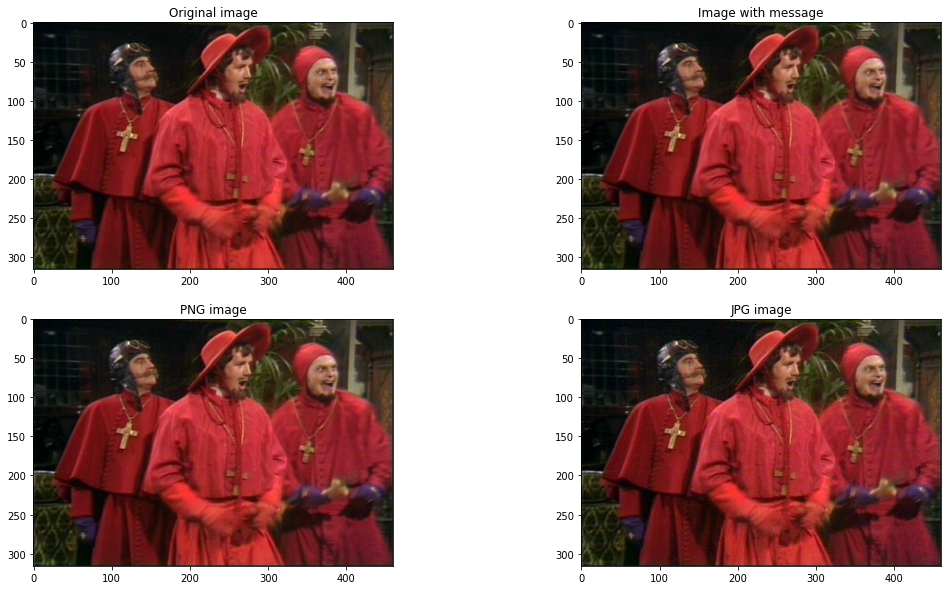

In [63]:
"""Function definitions that are used in LSB steganography."""
from matplotlib import pyplot as plt
import numpy as np
import binascii
import cv2 as cv
import math
plt.rcParams["figure.figsize"] = (18,10)


def encode_as_binary_array(msg):
    """Encode a message as a binary string."""
    msg = msg.encode("utf-8")
    msg = msg.hex()
    msg = [msg[i:i + 2] for i in range(0, len(msg), 2)]
    msg = [ "{:08b}".format(int(el, base=16)) for el in msg]
    return "".join(msg)


def decode_from_binary_array(array):
    """Decode a binary string to utf8."""
    array = [array[i:i+8] for i in range(0, len(array), 8)]
    if len(array[-1]) != 8:
        array[-1] = array[-1] + "0" * (8 - len(array[-1]))
    array = [ "{:02x}".format(int(el, 2)) for el in array]
    array = "".join(array)
    result = binascii.unhexlify(array)
    return result.decode("utf-8", errors="replace")


def load_image(path, pad=False):
    """Load an image.
    
    If pad is set then pad an image to multiple of 8 pixels.
    """
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    if pad:
        y_pad = 8 - (image.shape[0] % 8)
        x_pad = 8 - (image.shape[1] % 8)
        image = np.pad(
            image, ((0, y_pad), (0, x_pad) ,(0, 0)), mode='constant')
    return image


def save_image(path, image):
    """Save an image."""
    plt.imsave(path, image) 


def clamp(n, minn, maxn):
    """Clamp the n value to be in range (minn, maxn)."""
    return max(min(maxn, n), minn)


def hide_message(image, message, nbits=1):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks):
        byte = "{:08b}".format(image[i])
        new_byte = byte[:-nbits] + chunk
        image[i] = int(new_byte, 2)
        
    return image.reshape(shape)


def reveal_message(image, nbits=1, length=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = 0
    while i < length_in_pixels:
        byte = "{:08b}".format(image[i])
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message


original_image = load_image("images/spanish.png")  # Wczytanie obrazka
# Mnożenie stringów działa jak zwielokratnianie
message = "wiadomosc testowa" * 1
n = 1  # liczba najmłodszych bitów używanych do ukrycia wiadomości

message = encode_as_binary_array(message)  # Zakodowanie wiadomości jako ciąg 0 i 1
image_with_message = hide_message(original_image, message, n)  # Ukrycie wiadomości w obrazku

save_image("images/zad1.png", image_with_message)  # Zapisanie obrazka w formacie PNG
save_image("images/zad1.jpg", image_with_message)  # Zapisanie obrazka w formacie JPG

image_with_message_png = load_image("images/zad1.png")  # Wczytanie obrazka PNG
image_with_message_jpg = load_image("images/zad1.jpg")  # Wczytanie obrazka JPG

secret_message_png = decode_from_binary_array(
    reveal_message(image_with_message_png, nbits=n, length=len(message)))  # Odczytanie ukrytej wiadomości z PNG
secret_message_jpg = decode_from_binary_array(
    reveal_message(image_with_message_jpg, nbits=n, length=len(message)))  # Odczytanie ukrytej wiadomości z JPG

print(secret_message_png)
print(secret_message_jpg)

# Wyświetlenie obrazków
f, ar = plt.subplots(2,2)
ar[0,0].imshow(original_image)
ar[0,0].set_title("Original image")
ar[0,1].imshow(image_with_message)
ar[0,1].set_title("Image with message")
ar[1,0].imshow(image_with_message_png)
ar[1,0].set_title("PNG image")
ar[1,1].imshow(image_with_message_jpg)
ar[1,1].set_title("JPG image")


# Zadanie 2

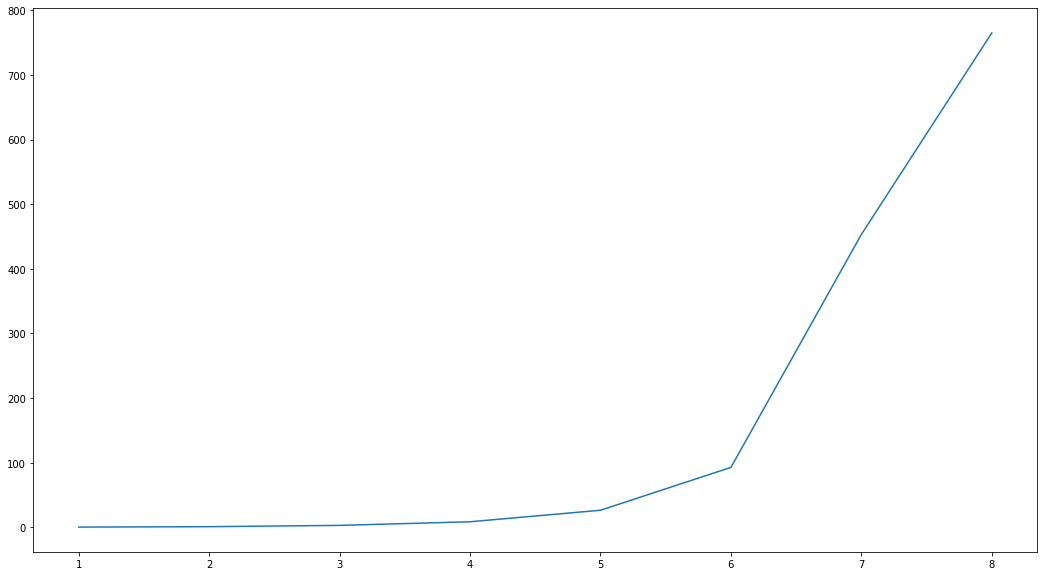

In [68]:
original_image = load_image("images/spanish.png")
message = "wiadomosc testowa" * 3000
message = encode_as_binary_array(message)

#print(original_image)

errors = []

for n in range(1,9):
    image_with_message = hide_message(original_image, message, n)
    save_image(f"images/zad2_{n}.png", image_with_message)
    image_with_message = load_image(f"images/zad2_{n}.png")

    sum = 0.0
    for x in range(len(original_image)):
        for y in range(len(original_image[x])):
            for c in range(3):
                sum += (int(original_image[x][y][c]) - int(image_with_message[x][y][c])) ** 2
    error = sum / (len(original_image) * len(original_image[0]) * 3)
    errors.append(error)

plt.plot([1,2,3,4,5,6,7,8], errors)
plt.show()


# Zadanie 3

In [101]:
def hide_message(image, message, nbits=1, spos=0):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > (len(image) - spos) * nbits:
        raise ValueError("Message is to long :(")
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks):
        byte = "{:08b}".format(image[i+spos])
        new_byte = byte[:-nbits] + chunk
        image[i+spos] = int(new_byte, 2)
        
    return image.reshape(shape)


def reveal_message(image, nbits=1, length=0, spos=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = 0
    while i < length_in_pixels:
        byte = "{:08b}".format(image[i+spos])
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message


original_image = load_image("images/spanish.png")
message = "wiadomosc testowa" * 5
message = encode_as_binary_array(message)

spos = 30000
n = 8
image_with_message = hide_message(original_image, message, n, spos)
save_image(f"images/zad3.png", image_with_message)
image_with_message = load_image("images/zad3.png")  # Wczytanie obrazka PNG

secret_message = decode_from_binary_array(
    reveal_message(image_with_message, nbits=n, length=len(message), spos=spos))

print(secret_message)



wiadomosc testowawiadomosc testowawiadomosc testowawiadomosc testowawiadomosc testowa


# Zadanie 4

In [85]:
#
# tu umieść kod
#

# Zadanie 5

In [86]:
#
# tu umieść kod
#